In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import seaborn as sb

pd.set_option('display.max_columns', None)

%matplotlib inline

#### Import the CSV files

In [2]:
df_raw = pd.read_csv("assets/airport_cancellations.csv")
df_cancl = df_raw.dropna()
df_cancl.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

In [3]:
df_raw2 = pd.read_csv("assets/airport_operations.csv")
df_ops = df_raw2.dropna() 
df_ops.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

In [ ]:
sb.pairplot(df_ops)

In [8]:
df_raw3 = pd.read_csv('assets/airports.csv')
df_ports = df_raw3.dropna()
df_ports.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

/Users/deepstructure/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


#### Merge the CSV files

In [9]:
df_ports.rename(columns={'locid':'airport'}, inplace=True)

In [10]:
df_all = df_cancl.merge(df_ops, on=['airport', 'year'])

In [11]:
df_all = df_all.merge(df_ports, on='airport')

In [12]:
# make sure we did the merges without creating null values
df_all.isnull().sum()

airport                               0
year                                  0
departure_cancellations               0
arrival_cancellations                 0
departure_diversions                  0
arrival_diversions                    0
departures_for_metric_computation     0
arrivals_for_metric_computation       0
percent_on-time_gate_departures       0
percent_on-time_airport_departures    0
percent_on-time_gate_arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average_taxi_out_delay                0
average_airport_departure_delay       0
average_airborne_delay                0
average_taxi_in_delay                 0
average_block_delay                   0
average_gate_arrival_delay            0
key                                   0
ap_name                               0
alias                                 0
facility_type                         0
faa_region                            0
county                                0


In [13]:
# delete unnecessary columns
del_list = ['facility_type', 'boundary_data_available', 'ap_type', 'alias', 'key']
for i in del_list:
    del df_all[i]

In [14]:
# create column list of numerical value columns
column_list = list(df_all.select_dtypes(include=['float64', 'int64']).columns)

#### Do a grouping to find the overall worse offenders

In [15]:
# create a series where all the information for each airport has been collapsed into one row per airport
newdf = df_all.groupby(['airport']).mean()

In [16]:
newdf.shape

(74, 20)

In [17]:
newdf.head(3)

,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,latitude,longitude
airport,,,,,,,,,,,,,,,,,,,,
ABQ,2009.0,281.545455,241.636364,73.090909,51.818182,44830.454545,44947.272727,0.801800,0.775791,0.786673,10.964545,10.211818,2.319091,12.534545,1.870000,0.955455,2.336364,11.314545,35.040194,-106.609194
ANC,2009.0,277.545455,340.909091,81.545455,43.090909,67627.545455,63188.454545,0.796600,0.770364,0.778991,14.769091,12.317273,1.977273,16.006364,4.100000,0.582727,4.797273,15.675455,61.174083,-149.998194
ATL,2009.0,6562.363636,7317.272727,884.454545,872.181818,469004.000000,465716.909091,0.771836,0.633418,0.771736,13.477273,19.768182,7.777273,20.069091,3.278182,3.586364,4.200000,14.543636,33.636700,-84.427864


In [18]:
# create a dataframe of the worst offfenders in each category
newdf2 = df_all.groupby(['airport']).mean().max()
del newdf2['year']

In [19]:
newdf2

departure_cancellations                10892.000000
arrival_cancellations                  11730.454545
departure_diversions                     884.454545
arrival_diversions                      1221.818182
departures_for_metric_computation     469004.000000
arrivals_for_metric_computation       465716.909091
percent_on-time_gate_departures            0.888100
percent_on-time_airport_departures         0.881027
percent_on-time_gate_arrivals              0.864709
average_gate_departure_delay              21.885455
average_taxi_out_time                     28.612727
average_taxi_out_delay                    11.985455
average_airport_departure_delay           27.867273
average_airborne_delay                     6.354545
average_taxi_in_delay                      4.181818
average_block_delay                        5.265455
average_gate_arrival_delay                22.568182
latitude                                  61.174083
longitude                                -66.002004
dtype: float

In [20]:
# unfortunately this doesn't include which airport that value is associated with, so...

worse = []
for i, n in enumerate(newdf2):
    worse.append((newdf[newdf[newdf2.index[i]] == n].index[0], newdf2.index[i], n))

In [21]:
worse_df = pd.DataFrame(worse, columns = ['airport', 'feature', 'value'])

In [22]:
# caveat, this also includes the best of the only three positive categories:
# percent_on-time_gate_departures            0.888100
# percent_on-time_airport_departures         0.881027
# percent_on-time_gate_arrivals              0.864709

worse_df

,airport,feature,value
0,ORD,departure_cancellations,10892.000000
1,ORD,arrival_cancellations,11730.454545
2,ATL,departure_diversions,884.454545
3,DFW,arrival_diversions,1221.818182
4,ATL,departures_for_metric_computation,469004.000000
5,ATL,arrivals_for_metric_computation,465716.909091
6,OGG,percent_on-time_gate_departures,0.888100
7,OGG,percent_on-time_airport_departures,0.881027
8,OGG,percent_on-time_gate_arrivals,0.864709
9,HPN,average_gate_departure_delay,21.885455


In [23]:
# check out distribution
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
 
for i in column_list[:-2]:
    b = normaltest(df_all[i])
    print i,'| pvalue:', b[1]

year | pvalue: 2.90654736192e-133
departure_cancellations | pvalue: 8.25328994944e-148
arrival_cancellations | pvalue: 7.77969960514e-147
departure_diversions | pvalue: 8.60339395567e-74
arrival_diversions | pvalue: 4.66736795099e-118
departures_for_metric_computation | pvalue: 3.41513560439e-49
arrivals_for_metric_computation | pvalue: 2.45289650928e-49
percent_on-time_gate_departures | pvalue: 2.92555386255e-28
percent_on-time_airport_departures | pvalue: 6.39110788886e-31
percent_on-time_gate_arrivals | pvalue: 7.24916037647e-28
average_gate_departure_delay | pvalue: 1.47697367715e-10
average_taxi_out_time | pvalue: 8.3621133013e-65
average_taxi_out_delay | pvalue: 4.29652570434e-101
average_airport_departure_delay | pvalue: 4.9703692117e-43
average_airborne_delay | pvalue: 9.10349823336e-32
average_taxi_in_delay | pvalue: 6.10991883595e-56
average_block_delay | pvalue: 8.0599290499e-25
average_gate_arrival_delay | pvalue: 3.90214684955e-30


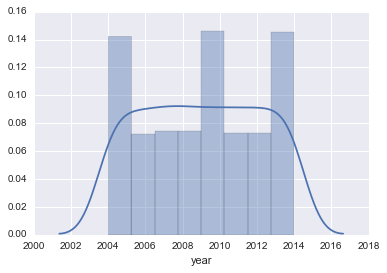

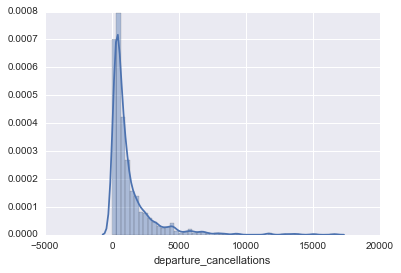

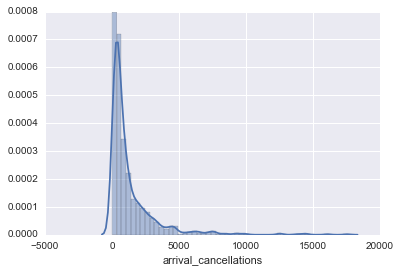

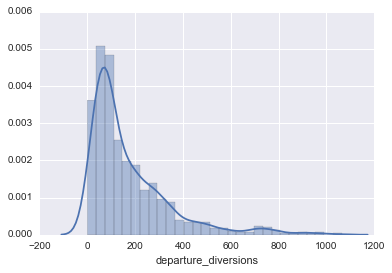

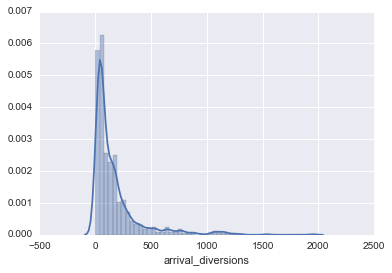

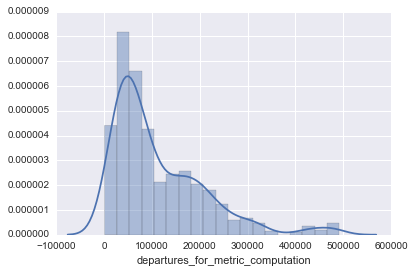

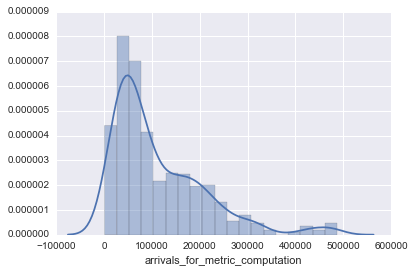

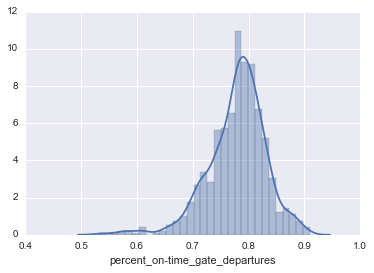

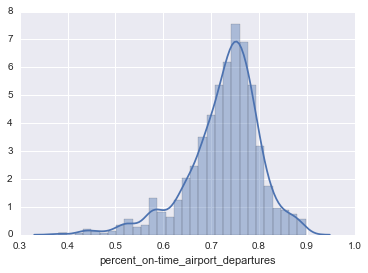

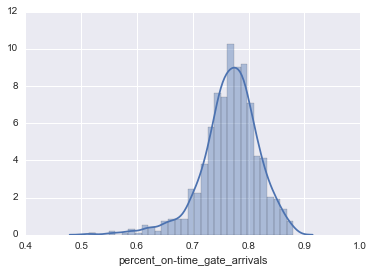

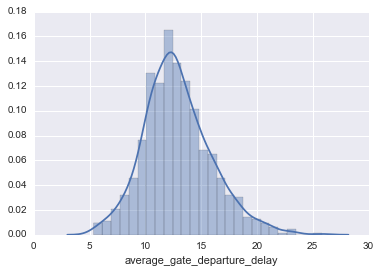

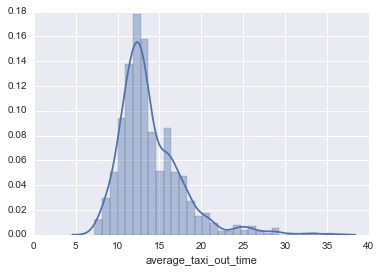

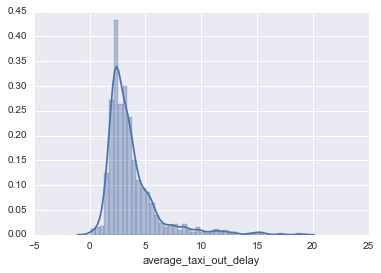

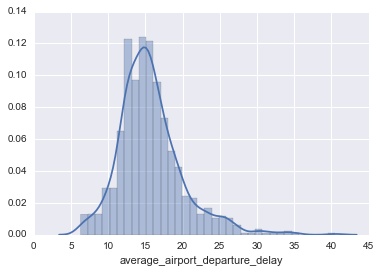

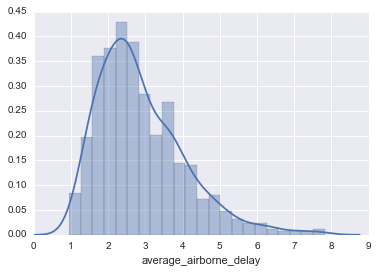

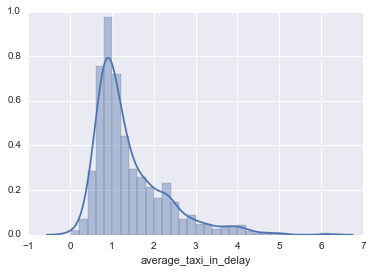

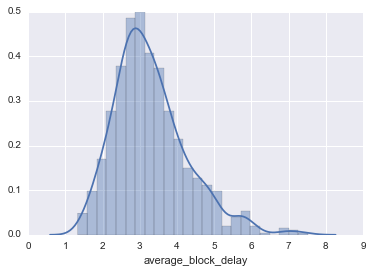

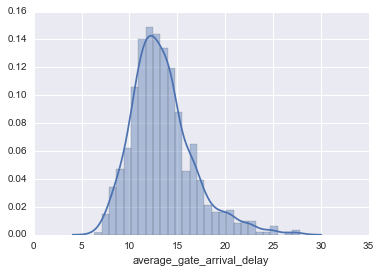

In [24]:
# that wasn't very helpful. let's try some graphs...

for i in column_list[:-2]:
    sb.distplot(df_all[i])
    plt.show()

In [25]:
# create dataframe of just the numerical values
X = df_all[column_list]

#### Experiment to see if KMeans would cluster according to the FAA regions
- when given the same cluster amount as the regions

In [26]:
from sklearn.preprocessing import StandardScaler
X_stand = StandardScaler().fit_transform(X)

In [27]:
len(df_all['faa_region'].unique())

9

In [28]:
from sklearn.cluster import KMeans

In [29]:
km = KMeans(n_clusters=9)
km_results = km.fit(X_stand)

In [30]:
from sklearn.metrics import adjusted_mutual_info_score
adjusted_mutual_info_score(km.labels_, df_all['faa_region'])


0.16332559450571618

In [31]:
# Conclusion: apparently not

In [32]:
# trying John's PCA-first methodology
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=2)
pca.fit(X_stand)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [34]:
from pprint import pprint
pprint (vars(pca))

{'components_': array([[-0.04016523,  0.26280925,  0.26087892,  0.23953515,  0.24584764,
         0.24983094,  0.24952518, -0.16915588, -0.27448352, -0.15445001,
         0.20548373,  0.26668827,  0.27279458,  0.2816328 ,  0.20332507,
         0.25883507,  0.21958441,  0.21472033,  0.06900428,  0.12827134],
       [-0.00719608, -0.18548465, -0.19649746, -0.27787944, -0.21599068,
        -0.27896041, -0.2795491 , -0.33160472, -0.21050496, -0.38148032,
         0.3231351 , -0.04888779, -0.03111888,  0.21709254,  0.0477766 ,
        -0.18986234,  0.09521276,  0.31409856,  0.07724844,  0.20092461]]),
 'copy': True,
 'explained_variance_': array([ 9.35644975,  4.33096464]),
 'explained_variance_ratio_': array([ 0.46782249,  0.21654823]),
 'iterated_power': 'auto',
 'mean_': array([  7.78128778e-15,   0.00000000e+00,  -1.77858006e-17,
         7.11432026e-17,   0.00000000e+00,  -5.33574019e-17,
         7.11432026e-17,   1.14718414e-15,  -7.29217826e-16,
        -3.21922992e-15,  -5.86931421

In [35]:
# well this doesn't prove anything
pd.DataFrame(pca.components_, columns=column_list).T

,0,1
year,-0.040165,-0.007196
departure_cancellations,0.262809,-0.185485
arrival_cancellations,0.260879,-0.196497
departure_diversions,0.239535,-0.277879
arrival_diversions,0.245848,-0.215991
departures_for_metric_computation,0.249831,-0.278960
arrivals_for_metric_computation,0.249525,-0.279549
percent_on-time_gate_departures,-0.169156,-0.331605
percent_on-time_airport_departures,-0.274484,-0.210505
percent_on-time_gate_arrivals,-0.154450,-0.381480


In [36]:
# removing the features that don't seem relevent
remover =  ['year', 'latitude', 'longitude', 'percent_on-time_gate_arrivals',
           'percent_on-time_airport_departures', 'percent_on-time_gate_departures']
column_list2 = [i for i in column_list if i not in remover]

In [37]:
column_list2

['departure_cancellations',
 'arrival_cancellations',
 'departure_diversions',
 'arrival_diversions',
 'departures_for_metric_computation',
 'arrivals_for_metric_computation',
 'average_gate_departure_delay',
 'average_taxi_out_time',
 'average_taxi_out_delay',
 'average_airport_departure_delay',
 'average_airborne_delay',
 'average_taxi_in_delay',
 'average_block_delay',
 'average_gate_arrival_delay']

In [38]:
X2 = df_all[column_list2]
X2_stand = StandardScaler().fit_transform(X2)
pca2 = PCA(n_components=2)
pca2.fit(X2_stand)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
# this doesn't seem any better, or I don't understand what PCA is supposed to do
pd.DataFrame(pca2.components_, columns=column_list2).T

,0,1
departure_cancellations,0.302562,-0.138365
arrival_cancellations,0.302210,-0.154566
departure_diversions,0.292481,-0.268606
arrival_diversions,0.289626,-0.182089
departures_for_metric_computation,0.302891,-0.255345
arrivals_for_metric_computation,0.302640,-0.256646
average_gate_departure_delay,0.158552,0.444343
average_taxi_out_time,0.286629,0.106630
average_taxi_out_delay,0.288579,0.123655
average_airport_departure_delay,0.255493,0.379182


In [40]:
print 'pca variance ratio', pca.explained_variance_ratio_
print 'pca2 variance ratio', pca2.explained_variance_ratio_

pca variance ratio [ 0.46782249  0.21654823]
pca2 variance ratio [ 0.59098436  0.19079578]


In [41]:
# I have no idea what I'm doing here...taking a guess.
# Going to use pca2 to transform my 'X2_stand' set of data and then cluster it 
X2_pca2 = pca2.transform(X2_stand)

In [42]:
# now to cluster it via KMeans into two groups (for bad and good?)
km2 = KMeans(n_clusters=2)
km2_results = km2.fit(X2_pca2)
labels = km2_results.labels_
centroids = km2_results.cluster_centers_

In [43]:
# just checking that I have all the rows
print X.shape
print X2_pca2.shape

(799, 20)
(799, 2)


In [44]:
# got the right about of labels?
np.unique(labels)

array([0, 1], dtype=int32)

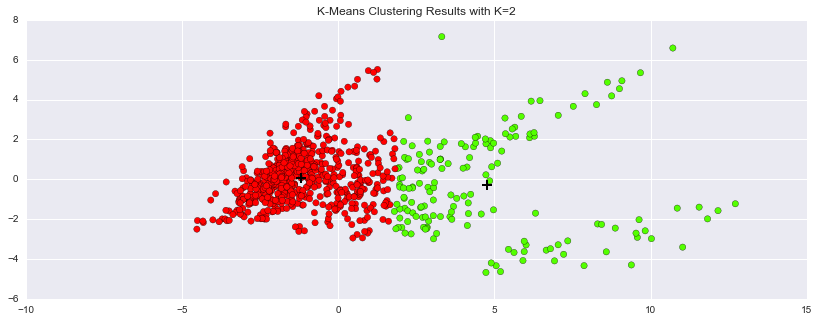

In [45]:
# lets graph that...

fig, (ax1) = plt.subplots(1, figsize=(14,5))

ax1.scatter(X2_pca2[:,0], X2_pca2[:,1], s=40, c=labels, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(centroids[:,0], centroids[:,1], marker='+', s=100, c='k', linewidth=2)
plt.show()

In [46]:
# original dataframe, add column for classification
df_all['g2b'] = labels

In [47]:
# what does 0 or 1 mean? Does it line up with my list of bad aiports?
worse_df

,airport,feature,value
0,ORD,departure_cancellations,10892.000000
1,ORD,arrival_cancellations,11730.454545
2,ATL,departure_diversions,884.454545
3,DFW,arrival_diversions,1221.818182
4,ATL,departures_for_metric_computation,469004.000000
5,ATL,arrivals_for_metric_computation,465716.909091
6,OGG,percent_on-time_gate_departures,0.888100
7,OGG,percent_on-time_airport_departures,0.881027
8,OGG,percent_on-time_gate_arrivals,0.864709
9,HPN,average_gate_departure_delay,21.885455


In [48]:
# seems to...
# (0 = good, 1 = bad)
# ORD, ATL, DFW, EWR, JFK and LGA were all in my worst list (worst_df)

# except I forgot this was being done by year, so a few aiports were classified differently
# on different years, thus returning a non-int value.

goodness = pd.DataFrame(df_all.groupby(['airport'])['g2b'].mean()).sort_values('g2b', ascending=False)
goodness

,g2b
airport,
ORD,1.000000
ATL,1.000000
EWR,1.000000
DFW,1.000000
LGA,1.000000
IAH,1.000000
JFK,1.000000
PHL,0.909091
LAX,0.909091


In [49]:
# amount of non-int values for good/bad
len(goodness[(goodness['g2b'] != 0) & (goodness['g2b'] != 1)])

17

In [50]:
# an example, Philidelphia, the first non-int score when the df is sorted from high to low
# Philly had one year that wasn't classified as bad

df_all[df_all['airport'] == 'PHL'][['airport', 'g2b', 'year']]

,airport,g2b,year
568,PHL,1,2004.0
569,PHL,1,2005.0
570,PHL,1,2006.0
571,PHL,1,2007.0
572,PHL,1,2008.0
573,PHL,1,2009.0
574,PHL,1,2010.0
575,PHL,1,2011.0
576,PHL,0,2012.0
577,PHL,1,2013.0


In [51]:
# now that I have a 1 or 0 classification for my dataframe, I'm going to run a logistical regression to define 
# feature importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [52]:
y = df_all['g2b']

X_train, X_test, y_train, y_test = train_test_split(X_stand, y, test_size=0.3)

log = LogisticRegression(penalty='l1')
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
log.score(X_test, y_test)

0.9916666666666667

In [54]:
log.coef_

array([[ 0.24319633,  2.08960335,  1.37788241,  0.02877488,  0.77309519,
         0.        ,  2.25616298,  0.        , -0.24412263,  0.        ,
         0.        ,  0.01517877,  1.40071143,  0.4846124 ,  0.69780668,
         1.4607824 ,  0.43291575,  0.88076624,  0.        ,  0.        ]])

In [55]:
zip(log.coef_, X.columns)

[(array([ 0.24319633,  2.08960335,  1.37788241,  0.02877488,  0.77309519,
          0.        ,  2.25616298,  0.        , -0.24412263,  0.        ,
          0.        ,  0.01517877,  1.40071143,  0.4846124 ,  0.69780668,
          1.4607824 ,  0.43291575,  0.88076624,  0.        ,  0.        ]),
  'year')]

In [56]:
for i in log.coef_:
    coefs = pd.DataFrame(zip(i, X.columns))

In [57]:
# hmmm....
coefs.sort_values(0, ascending=False)

,0,1
6,2.256163,arrivals_for_metric_computation
1,2.089603,departure_cancellations
15,1.460782,average_taxi_in_delay
12,1.400711,average_taxi_out_delay
2,1.377882,arrival_cancellations
17,0.880766,average_gate_arrival_delay
4,0.773095,arrival_diversions
14,0.697807,average_airborne_delay
13,0.484612,average_airport_departure_delay
16,0.432916,average_block_delay


#### In conclusion: 
I don't really know what I did here. Given the ridiculously high accuracy rate of the logistical regression I'm assuming something is wrong, but I don't know what. I also don't see, beyond the obvious fact that departure cancellations are bad and thus contribute to a 1 score for an airport, that anything useful was noted here.